In [1]:
# just imports
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split

In [2]:
# local imports
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.loss_funcs import VAE_Loss
from VAE import vae_models

In [8]:
%%time
data_path = '../data/'
aug=1

lrg_data_set   = LRG(use_kittler=True, n_aug=aug, blur=True, 
                     catalog_dir=data_path + 'catalog/mrt-table3.txt', file_dir=data_path + 'lrg')
data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=128, shuffle=False)

../data/lrg:	1442/1442
CPU times: user 34.9 s, sys: 37.7 s, total: 1min 12s
Wall time: 24 s


In [9]:
lbs = np.array(lrg_data_set.labels)
lbs = lbs[lbs > 0]
lbs = lbs[lbs>2]
np.sum(lbs > 3)
# len(lrg_data_set.labels)
# set(lbs)

114

In [10]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4, k=None, batch_norm=True):
        super(VAE, self).__init__()
        self.k = k
        n_layers = len(self.k)
        encoder_layers = []
        decoder_layers = []
        
        for i in range( n_layers -1) :
            in_c, out_c = self.k[i], self.k[i + 1]
            if(in_c == 'M'): continue
            stride = 1
            if out_c == 'M':
                stride = 2
                i += 1
                out_c = self.k[i + 1]
            layer = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
            encoder_layers.append(layer)
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(out_c))
            encoder_layers.append(nn.ReLU(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        
        for i in range(n_layers - 1, 0, -1):
            in_c, out_c = self.k[i], self.k[i - 1]
            if(in_c == 'M'): continue
            stride = 1
            output_padding=0
            if out_c == 'M':
                stride = 2
                i -= 1
                out_c = self.k[i - 1]
                output_padding=1
                
            layer = nn.ConvTranspose2d(in_c, out_c, kernel_size=3, padding=1, 
                                       output_padding=output_padding, stride=stride)
            decoder_layers.append(layer)
            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(out_c))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
        
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if self.training :
            return mu + eps*std
        return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x))
        x = x.view(-1, self.k[-1], 2, 2) #reshape
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [11]:
model = torch.load('SimpleBVAE_pow_07')

In [12]:
sample = iter(data_loader_lrg).next()
s = sample[0][1:2]
with torch.no_grad():
    e = model.encode(s.to('cuda'))[0]
    d = model.decode(e).to('cpu')

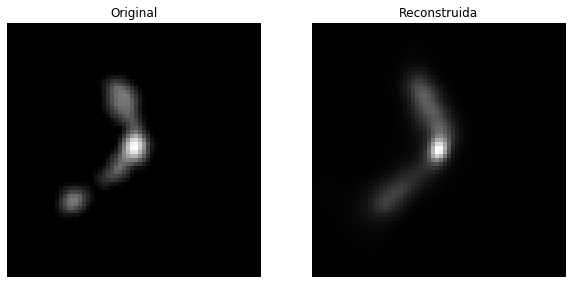

In [13]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Original')
ax[1].set_title('Reconstruida')
ax[0].imshow(s[0][0], cmap='gray')
ax[1].imshow(d[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

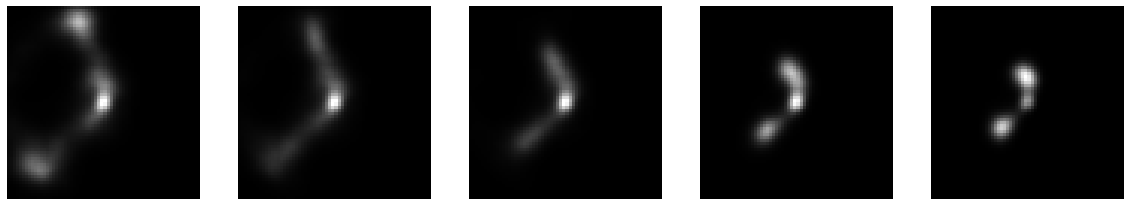

In [40]:
# [1, 1, 2, 2, 2, 2, 2]
j = 7

m = 2
ar = np.arange(-1, 1.5, .5)
f, ax = plt.subplots(1, len(ar), figsize=(20, 5))

for k, i in enumerate(ar):
    b = torch.tensor(e)
    b[0][j] = e[0][j] + m*i
    
    with torch.no_grad():
        d = model.decode(b).cpu()[0][0]
    ax[k].imshow(d, cmap='gray')
    ax[k].set_aspect('equal')
    ax[k].axis('off')

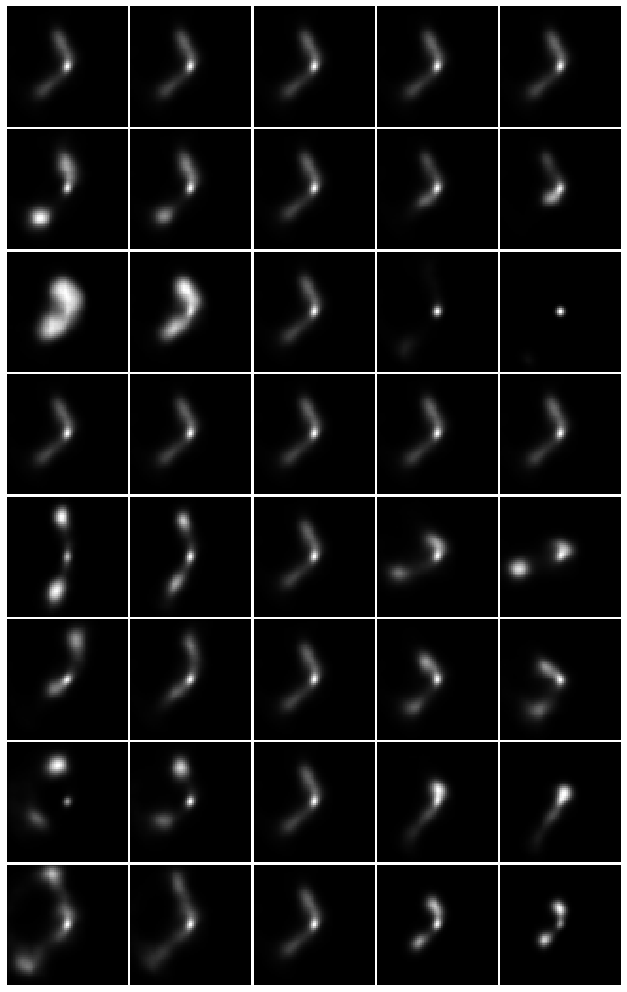

In [42]:
fig = plt.figure(figsize=(11, 18))
gs1 = gridspec.GridSpec(8,5, figure=fig)
gs1.update(wspace=0.02, hspace=0.02) # set the spacing between axes.

m_vecotr = [1, 1, 2, 2, 2, 2, 2, 2]

for j in range(8):
    for k, i in enumerate(np.arange(-1, 1.5, .5)):
        ax1 = plt.subplot(gs1[j*5+k])
        plt.axis('off')
        b = torch.tensor(e)
        b[0][j] = e[0][j] + m_vecotr[j]*i
        with torch.no_grad():
            d = model.decode(b).cpu()[0][0]
        ax1.imshow(d, cmap='gray')
        ax1.set_aspect('equal')
plt.show()

In [10]:
model.eval()
enc_vals = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(data_loader_lrg):
        e = model.encode(data.to('cuda'))[0]
        enc_vals += (e.to('cpu').tolist())
        labels += target.tolist()
enc_vals = np.array(enc_vals)

In [11]:
Y = np.array(labels)

In [12]:
X = enc_vals
Y = np.array(labels)

In [13]:
from sklearn.manifold import TSNE

In [14]:
X_embedded = TSNE(n_components=2).fit_transform(X)

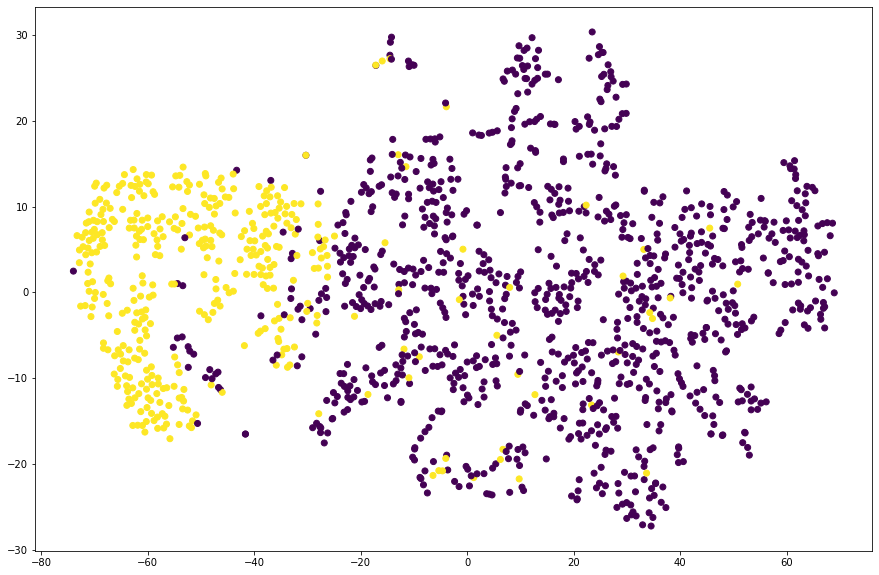

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=Y==0)
plt.show()

In [16]:
Y2 = Y[Y > 0]
X_embedded2 = X_embedded[Y > 0]

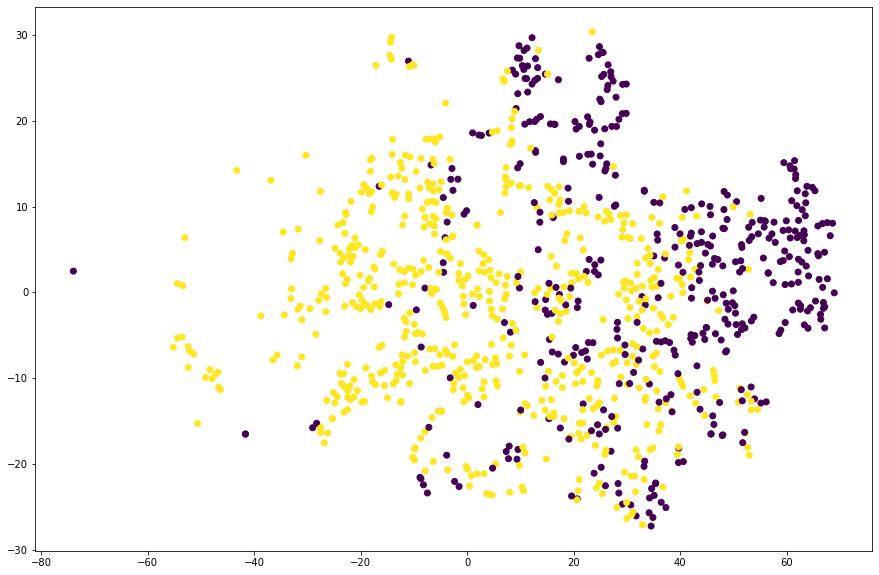

In [17]:
plt.figure(figsize=(15,10))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c = Y2 < 3)
plt.show()

In [18]:
Y2 = Y[Y < 3]
X_embedded2 = X_embedded[Y < 3]

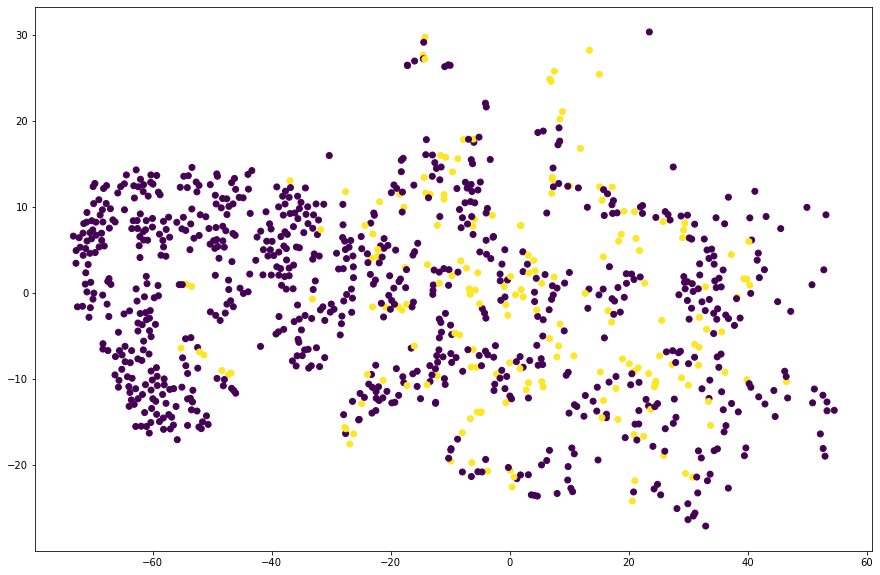

In [19]:
plt.figure(figsize=(15,10))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c = Y2 == 1)
plt.show()

In [44]:
s.shape

torch.Size([1, 1, 64, 64])